In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

Here we're going to go through a basic Naive Bayes classifier. Specifically we're going to build a spam filter. As we've said before, this is a classic use for this kind of classifier and it's not too difficult to set up. The dataset we'll work with is UC Irvine's SMS spam dataset.

This dataset has a few nice attributes. Firstly, it's pre-labelled, which is great for our purposes as we don't have to make our own spam/ham labels ('ham' being the common term to denote a message that is not spam). Secondly, the dataset is relatively small, which will allow us to show off one of the great things about Naive Bayes, its ability to train on relatively little data while achieving reasonable accuracy.

In [3]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
             "master/sms_spam_collection/SMSSpamCollection"
            )
sms_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
sms_raw.columns = ['spam', 'message']

In [4]:
keywords = ['click', 'offer', 'winner', 'buy', 'free', 'cash', 'urgent', 'limited']

for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    sms_raw[str(key)] = sms_raw.message.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

In [5]:
sms_raw['allcaps'] = sms_raw.message.str.isupper()

In [6]:
sms_raw['spam'] = (sms_raw['spam'] == 'spam')
# Note that if you run this cell a second time everything will become false.
# So... Don't.

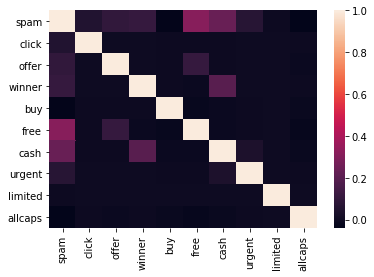

In [7]:
sns.heatmap(sms_raw.corr())

In [8]:
data = sms_raw[keywords + ['allcaps']]
target = sms_raw['spam']

In [9]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 5572 points : 604


## Success metric

In [10]:
print('The success rate of this classifier is {}%'.format(((5572-604)/5572)*100))

The success rate of this classifier is 89.16008614501077%


The next level of analysis of your classifier is often something called a Confusion Matrix. This is a matrix that shows the count of each possible permutation of target and prediction. So in our case, it will show the counts for when a message was ham and we predicted ham, when a message was ham and we predicted spam, when a message was spam and we predicted ham, and when a message was spam and we predicted spam.

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[4770,   55],
       [ 549,  198]])

### Calculate the confusion matrix without sklearn

In [12]:
# Build your confusion matrix and calculate sensitivity and specificity here.
count_tl=0
count_tr=0
count_bl=0
count_br=0
for x in sms_raw.index:
    if sms_raw.spam.loc[x] == False and (sms_raw.click.loc[x] == False and sms_raw.offer.loc[x] == False and sms_raw.winner.loc[x] == False and sms_raw.buy.loc[x] == False and sms_raw.free.loc[x] == False and sms_raw.cash.loc[x] == False and sms_raw.urgent.loc[x] == False and sms_raw.limited.loc[x]==False and sms_raw.allcaps.loc[x] == False):
        count_tl=count_tl + 1
    elif sms_raw.spam.loc[x] == False and (sms_raw.click.loc[x] == True or sms_raw.offer.loc[x] == True or sms_raw.winner.loc[x] == True or sms_raw.buy.loc[x] == True or sms_raw.free.loc[x] == True or sms_raw.cash.loc[x] == True or sms_raw.urgent.loc[x] == True or sms_raw.limited.loc[x] ==True or sms_raw.allcaps.loc[x] == True):
        count_tr=count_tr+1
    elif sms_raw.spam.loc[x] == True and (sms_raw.click.loc[x] == False and sms_raw.offer.loc[x] == False and sms_raw.winner.loc[x] == False and sms_raw.buy.loc[x] == False and sms_raw.free.loc[x] == False and sms_raw.cash.loc[x] == False and sms_raw.urgent.loc[x] == False and sms_raw.limited.loc[x]==False and sms_raw.allcaps.loc[x] == False):
        count_bl=count_bl+1
    elif sms_raw.spam.loc[x] == True and (sms_raw.click.loc[x] == True or sms_raw.offer.loc[x] == True or sms_raw.winner.loc[x] == True or sms_raw.buy.loc[x] == True or sms_raw.free.loc[x] == True or sms_raw.cash.loc[x] == True or sms_raw.urgent.loc[x] == True or sms_raw.limited.loc[x] ==True or sms_raw.allcaps.loc[x] == True):
        count_br=count_br+1
    
print(count_tl, count_tr)
print(count_bl, count_br)

print('The sensitivity of this model is {}%'.format((count_br/(count_tr+count_bl))*100))
print('The specificity of this model is {}%'.format((count_tl/4825)*100))


4629 196
545 202
The sensitivity of this model is 27.26045883940621%
The specificity of this model is 95.93782383419689%


## Cross validation

In [13]:
# Test your model with different holdout groups.

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.884304932735426
Testing on Sample: 0.8916008614501076


In [14]:
# run cross validation on data
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([0.89784946, 0.89426523, 0.89426523, 0.890681  , 0.89605735,
       0.89048474, 0.88150808, 0.89028777, 0.88489209, 0.89568345])

### Calculate cross validation without sklearn

In [51]:
# randomize dataframe
sms_random=sms_raw.sample(frac=1)
for i in range(10):
    # create train and test populations
    train=sms_random.sample(frac=0.1)
    test=sms_random.drop(train.index)
    # get truth and false values for testing
    data_tr = train[keywords + ['allcaps']]
    target_tr = train['spam']
    # re-classify the data for each sample
    from sklearn.naive_bayes import BernoulliNB
    bnb_tr = BernoulliNB()
    y_pred_tr = bnb_tr.fit(data_tr, target_tr).predict(data_tr)
    # print success metrics of each train population
    print(((target_tr == y_pred_tr).sum())/len(target_tr))

0.8761220825852782
0.8850987432675045
0.8904847396768402
0.895870736086176
0.895870736086176
0.9012567324955116
0.9084380610412927
0.881508078994614
0.8779174147217235
0.8725314183123878


## What is a good score?

Using the topics we introduced earlier in this lesson, try to do a more in depth evaluation of the model looking at the kind of errors we're generating and what accuracy we'd get if we just randomly guessed. You may want to use what's known as a confusion matrix to show different kinds of errors.

In [56]:
# Perform your additional evaluation here.
# randomize dataframe
sms_random=sms_raw.sample(frac=1)
for i in range(10):
    # create train and test populations
    train=sms_random.sample(frac=0.1)
    test=sms_random.drop(train.index)
    # get truth and false values for testing
    data_tr = train[keywords + ['allcaps']]
    target_tr = train['spam']
    # re-classify the data for each sample
    from sklearn.naive_bayes import BernoulliNB
    bnb_tr = BernoulliNB()
    y_pred_tr = bnb_tr.fit(data_tr, target_tr).predict(data_tr)
    # print success metrics of each train population
    from sklearn.metrics import confusion_matrix
    print('The confusion matrix for this sample is {}'.format(confusion_matrix(target_tr, y_pred_tr)))

The confusion matrix for this sample is [[474   5]
 [ 56  22]]
The confusion matrix for this sample is [[480   4]
 [ 58  15]]
The confusion matrix for this sample is [[483   3]
 [ 56  15]]
The confusion matrix for this sample is [[473   6]
 [ 56  22]]
The confusion matrix for this sample is [[478   4]
 [ 59  16]]
The confusion matrix for this sample is [[480   2]
 [ 68   7]]
The confusion matrix for this sample is [[488   2]
 [ 50  17]]
The confusion matrix for this sample is [[467   5]
 [ 71  14]]
The confusion matrix for this sample is [[484   6]
 [ 52  15]]
The confusion matrix for this sample is [[472   6]
 [ 63  16]]


The confusion matrices for each test population show that the majority of the errors in this filter come from the bottom left corners of the matrices, or 'spam and predicted ham.' This means the filter is not correctly predicitng enough of the spam emails. In addition, the larger sample sizes show nuch larger erros in the top right corner of the matrix, or 'ham and predicted spam.' This shows that the filter will have many more errors when run with greater amounts of emails. Recommendations to fix this problem include:
- adding more keywords to the filter
- adding in a section that accounts for multiple excalamation points
- creating a better method to find proper spam keywords